# SHAP Tutorial

In this notebook, we provide an introductory tutorial to SHAP values with an XGBoost model, using urban heat island data from a previous paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
import shap
# import hyperparameter tuning library, if necessary

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
features = ['Black / African American', 'Hispanic / Latino', 'White', 'Below Federal Poverty Line', 
            'Population Density', 'Impervious Surface', 'DelNDVI_summer', 'Spatial Lag']
label = 'UHI_summer_day'

In [3]:
data = pd.read_csv('data/uhi.csv', usecols=features+[label])

In [4]:
pd.DataFrame({'Total Missing': data.isna().sum(), 
              'Percent Missing': (data.isna().sum() / len(data)) * 100 })

,Total Missing,Percent Missing
UHI_summer_day,222,0.397344
DelNDVI_summer,18,0.032217
Black / African American,335,0.599595
White,335,0.599595
Hispanic / Latino,335,0.599595
Below Federal Poverty Line,441,0.789318
Impervious Surface,1187,2.124537
Population Density,9,0.016109
Spatial Lag,0,0.000000


In [5]:
# We can drop the missing values or interpolate
data = data.interpolate(method='nearest')

In [6]:
# Separate the features and target
X, y = data[features], data[['UHI_summer_day']]

# Split the data into training/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Model Development

In [7]:
# Train a model using the scikit-learn API
model = XGBRegressor(n_estimators=100, objective='reg:squarederror', tree_method='hist', enable_categorical=True)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [8]:
# Make predictions with the test set
y_pred = model.predict(X_test)

In [9]:
# Evaluate the RMSE and R^2 with the test set
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

In [10]:
rmse, r2

(1.1518746453559172, 0.82674408553826)

## Model Interpretation
Let's use the SHAP API to interpret our model.

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

### SHAP Bar and Beeswarm
[SHAP Bar Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/bar.html)

[SHAP Beeswarm Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/beeswarm.html)

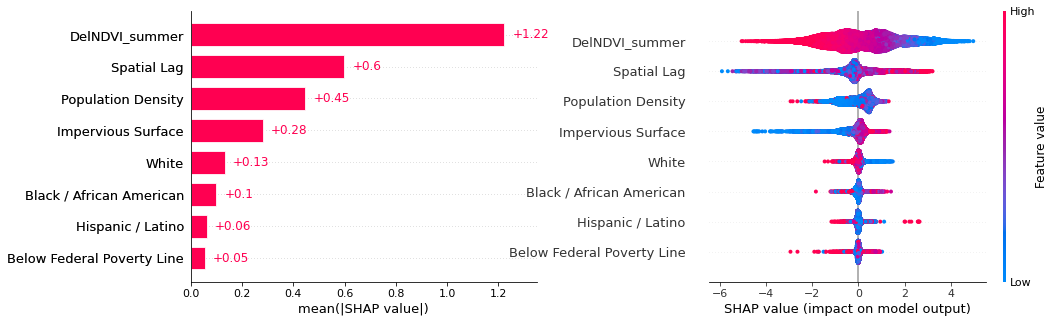

In [12]:
# Create a SHAP bar and beeswarm plot
plt.figure(figsize=(14,10))
plt.subplot(1,2,1)
shap.plots.bar(
    shap_values, max_display=10, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(
    shap_values, max_display=10, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1, 
    right=2.5, 
    top=0.9,
    wspace = 0.5)

### SHAP Scatter Plots
[SHAP Scatter Plots](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html)

Create a SHAP scatter plot by race. Show the interaction effect of poverty.

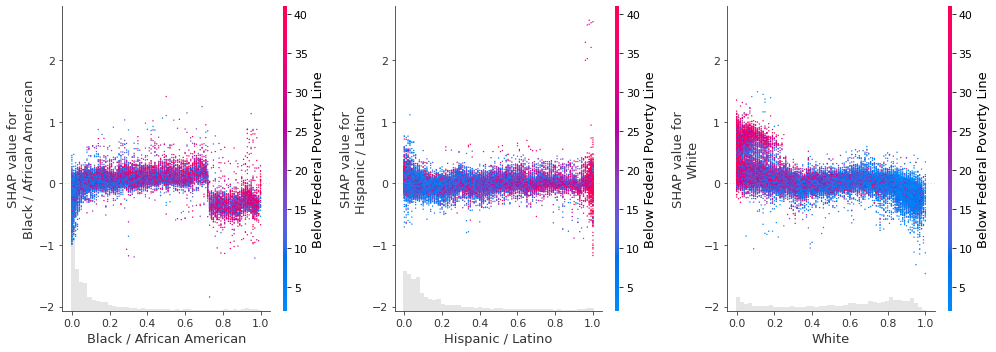

In [13]:
race = ['Black / African American', 'Hispanic / Latino', 'White']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), sharey=True)
for i in range(3):
    shap.plots.scatter(shap_values[:, race[i]], color=shap_values[:, 'Below Federal Poverty Line'], show=False, ax=axes[i], dot_size=2)

plt.tight_layout()

Create a SHAP scatter plot by race. Show the interaction effect of NDBI, NDVI, BSA, and population density.

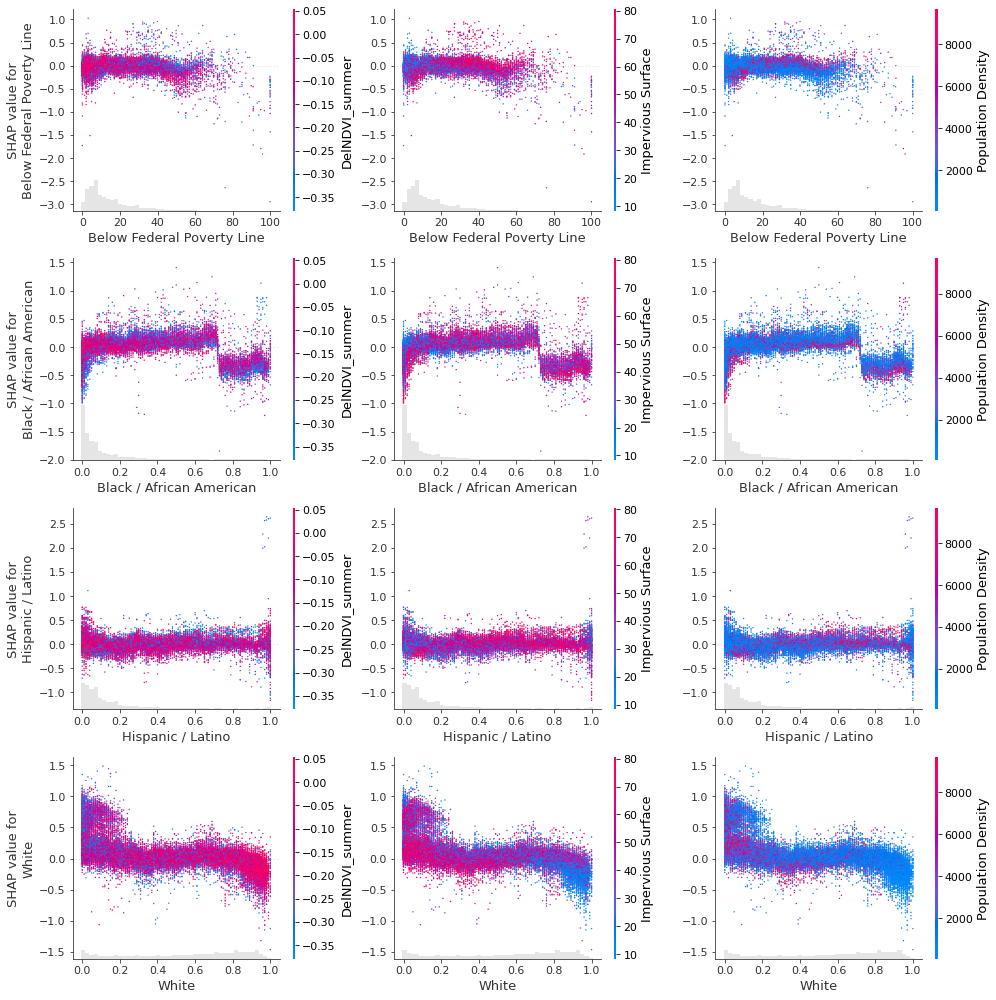

In [15]:
nrows, ncols = 4, 3
env = ['DelNDVI_summer', 'Impervious Surface', 'Population Density']
demo = ['Below Federal Poverty Line', 'Black / African American', 'Hispanic / Latino', 'White']
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,14))
for i in range(nrows):
    for j in range(ncols):
        shap.plots.scatter(shap_values[:, demo[i]], color=shap_values[:, env[j]], show=False, ax=axes[i,j], dot_size=2)
        if j > 0:
            axes[i,j].set(ylabel=None) # turn off y axis since it's redundant
        
plt.tight_layout()

### SHAP Partial Dependence Plots

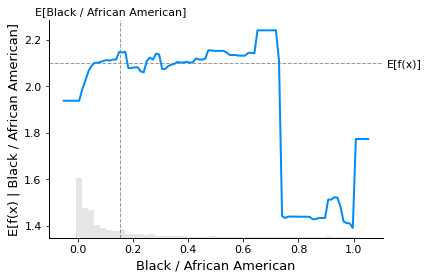

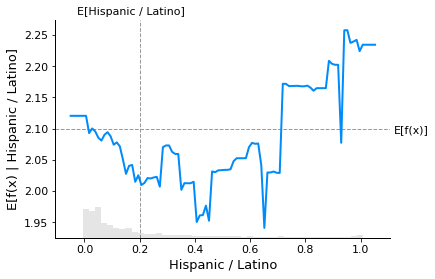

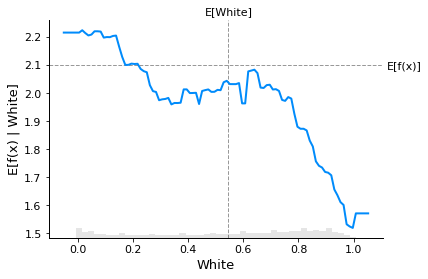

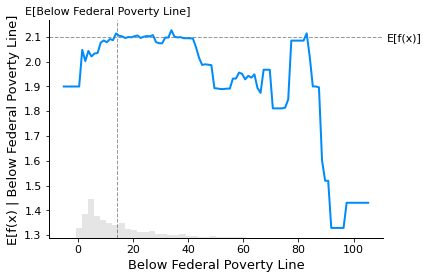

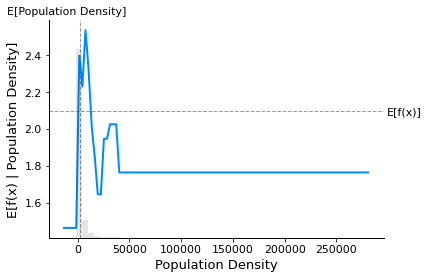

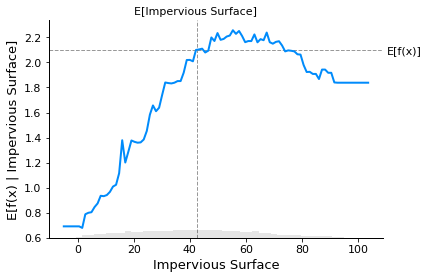

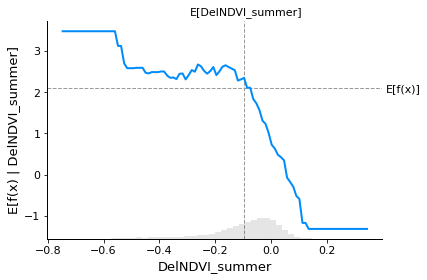

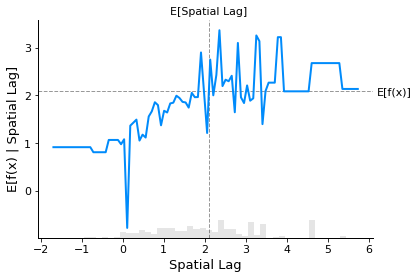

In [16]:
for i in range(8):
    shap.plots.partial_dependence(features[i], 
                                  model.predict, 
                                  data[features], 
                                  model_expected_value=True, 
                                  feature_expected_value=True, 
                                  ice=False, 
                                  show=False)